In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Get the current working directory
current_dir = os.getcwd()

# Construct the relative path to the data file
relative_path = os.path.join(current_dir, "thesis/data/review_data_new.csv")

# Read the data file into a Pandas DataFrame
df = pd.read_csv('/Users/blankajarmoszko/PycharmProjects/thesis/data/review_data_new.csv')


## Data Exploration

In [3]:

df.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments
0,The Stolen Heir,Emily May,"2,031",310k,4.0,Not quite The Cruel Prince but I enjoyed this ...,"1,206",3.0
1,The Stolen Heir,jessica,"2,563",42.2k,4.0,hmm. i didnt obsess over this one like i did w...,654,0.0
2,The Stolen Heir,katia,306,526,3.0,"3.5 ★oak was a disappointment, but suren!! i l...","1,233",0.0
3,The Stolen Heir,cor,269,74,NaN,OMG IM SHAKING IM SO EXCITED IM GOING TO CRY I...,610,0.0
4,The Stolen Heir,ale (semi hiatus) ‧ ₊˚୨ ♡ ୧ ₊˚,438,"2,598",NaN,"WE HAVE A COVER, OMG, WE HAVE A COVER!!!!I NEE...",746,0.0


In [4]:
df_cleaned = df[["star_rating",'review_text']].copy()
df_cleaned.dropna(subset=['star_rating','review_text'], inplace=True)

In [5]:
df_cleaned.head()

,star_rating,review_text
0,4.0,Not quite The Cruel Prince but I enjoyed this ...
1,4.0,hmm. i didnt obsess over this one like i did w...
2,3.0,"3.5 ★oak was a disappointment, but suren!! i l..."
6,3.0,Every single mention of Oak’s hooves was a jum...
7,4.0,4.5 stars ⭐️🧚🏻🥹


Number of rows per star rating:
sentiment
2    17996
1    14874
0    13876
Name: count, dtype: int64


/var/folders/66/n0_9mny57ys5rqmlmylz_2880000gn/T/ipykernel_3355/3910828417.py:16: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_cleaned['sentiment']).plot.bar(title="Sentiment distribution in df")


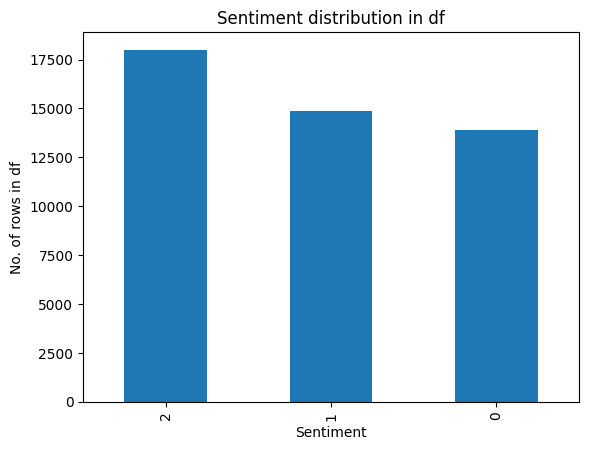

In [6]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 3:
        return 0
    elif stars_received <= 4:
        return 1
    else:
        return 2
# Mapping stars to sentiment into three categories
df_cleaned['sentiment'] = [ map_sentiment(x) for x in df_cleaned['star_rating']]
print("Number of rows per star rating:")
print(df_cleaned['sentiment'].value_counts())

# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df_cleaned['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

## Data Preprocessing

In [7]:
df_cleaned.head()

,star_rating,review_text,sentiment
0,4.0,Not quite The Cruel Prince but I enjoyed this ...,1
1,4.0,hmm. i didnt obsess over this one like i did w...,1
2,3.0,"3.5 ★oak was a disappointment, but suren!! i l...",0
6,3.0,Every single mention of Oak’s hooves was a jum...,0
7,4.0,4.5 stars ⭐️🧚🏻🥹,1


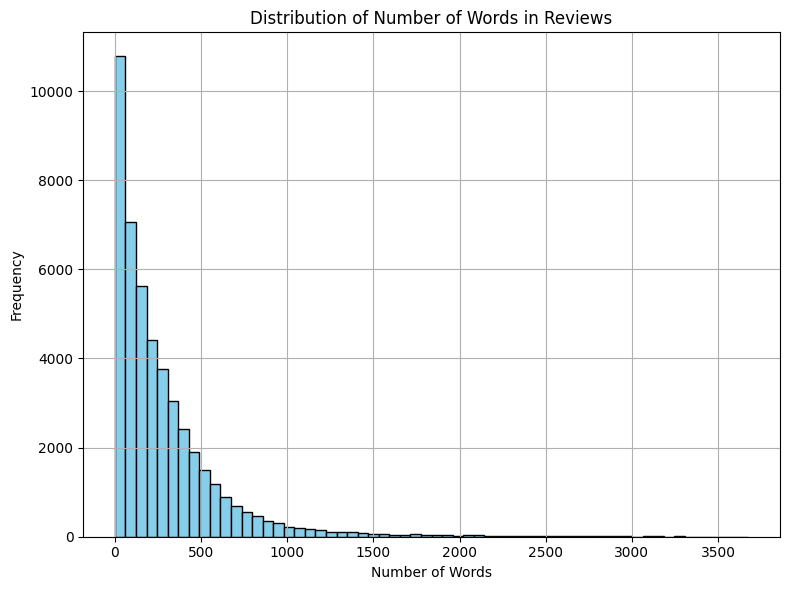

In [8]:
df_cleaned['num_words'] = df_cleaned['review_text'].apply(lambda x: len(x.split()))

# Plot the histogram with number of words
plt.figure(figsize=(8, 6))
plt.hist(df_cleaned['num_words'], bins=60, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Reviews')
plt.grid(True)  # Add grid lines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [9]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df_cleaned['review_text'], df_cleaned['sentiment'], 
                                                                    random_state=42, 
                                                                    test_size=0.3, 
                                                                    stratify=df_cleaned['sentiment'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [10]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

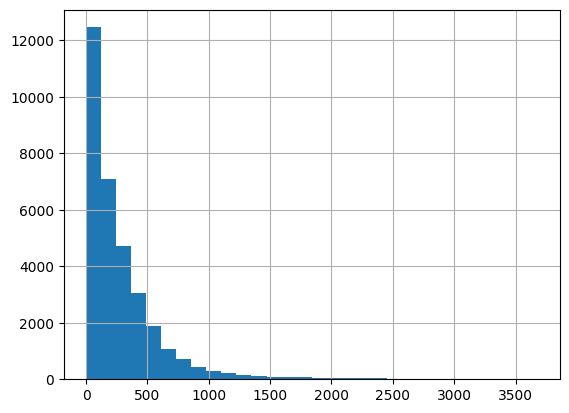

In [11]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [52]:
from transformers import AutoModel
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ",device)
model = AutoModel.from_pretrained(model_ckpt).to(device)

device:  cpu


In [53]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [54]:
df_cleaned = df_cleaned.rename(columns = {'review_text':'text','sentiment':'label'})

In [55]:
df_cleaned.head()

,star_rating,text,label,num_words
0,4.0,Not quite The Cruel Prince but I enjoyed this ...,1,84
1,4.0,hmm. i didnt obsess over this one like i did w...,1,97
2,3.0,"3.5 ★oak was a disappointment, but suren!! i l...",0,60
6,3.0,Every single mention of Oak’s hooves was a jum...,0,9
7,4.0,4.5 stars ⭐️🧚🏻🥹,1,3


In [35]:
from sklearn.model_selection import train_test_split

# Assuming df is your pandas DataFrame
df_train, df_test = train_test_split(df_cleaned, test_size=0.2, random_state=42)

In [36]:
import datasets
from datasets import Dataset, DatasetDict
from datasets import load_dataset


In [37]:
df_train = Dataset.from_pandas(df_train)
df_test = Dataset.from_pandas(df_test)

In [40]:
df_encoded_train = df_train.map(tokenize, batched=True, batch_size=None)
df_encoded_test = df_test.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/37396 [00:00<?, ? examples/s]

Map:   0%|          | 0/9350 [00:00<?, ? examples/s]

In [41]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
tokens2ids

[('[UNK]', 100), ('[SEP]', 102), ('[PAD]', 0), ('[CLS]', 101), ('[MASK]', 103)]

In [42]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [46]:
df_cleaned.label

0        1
1        1
2        0
6        0
7        1
        ..
50073    0
50075    1
50076    1
50077    2
50078    1
Name: label, Length: 46746, dtype: int64

In [44]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_cleaned['label'].names)

NameError: name 'hf_dataset' is not defined

In [47]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k: v.to(device) for k, v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

def analyze_error_test_set(df_encoded_src):
    df_encoded_src.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    df_encoded_src["validation"] = df_encoded_src["validation"].map(
        forward_pass_with_label, batched=True, batch_size=16)
    df_encoded_src.set_format("pandas")
    
    # Convert predicted labels to strings if necessary
    df_test = df_encoded_src["validation"][:][["text", "label"]]
    df_test["predicted_label"] = df_encoded_src["validation"]["predicted_label"]
    
    # Optionally convert labels to strings
    # df_test["label"] = df_test["label"].apply(lambda x: label_int2str.get(x))
    # df_test["predicted_label"] = df_test["predicted_label"].apply(lambda x: label_int2str.get(x))
    
    return df_test

In [48]:
from transformers import AutoModel
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ",device)
model = AutoModel.from_pretrained(model_ckpt).to(device)

device:  cpu


In [49]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

def encode_dataset(df_source):
  df_encoded = df_source.map(tokenize, batched=True, batch_size=None)
  df_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
  return df_encoded

def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

def extract_hidden_states_df(df_source):
  df_encoded = encode_dataset(df_source)
  df_hidden = df_encoded.map(extract_hidden_states, batched=True)
  return df_hidden

In [50]:
np.object = object

In [ ]:
import numpy as np

X_train = np.array(df_train[""])
X_valid = np.array(df_hidden["validation"]["hidden_state"])
X_test = np.array(df_hidden["test"]["hidden_state"])

y_train = np.array(df_hidden["train"]["label"])
y_valid = np.array(df_hidden["validation"]["label"])
y_test = np.array(df_hidden["test"]["label"])

X_train.shape, y_train.shape

In [51]:
encode_dataset(df_cleaned)

TypeError: tokenize() got an unexpected keyword argument 'batched'

In [26]:
df_cleaned.columns

Index(['star_rating', 'text', 'label', 'num_words'], dtype='object')

In [30]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [28]:
df_source = df_cleaned.copy()[["text", "label"]]

In [29]:
# Use whole dataset in Huggingface dataset format
batch = df_source
# Send inputs from CPU to GPU
inputs = {k:v.to(device) for k,v in batch.items()
          if k in tokenizer.model_input_names}
# Extract last hidden states
# Disable gradient calculation on PyTorch Side
with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
# Return latest hidden state as numpy matrix
df_hidden = last_hidden_state[:,0].cpu().numpy()

ValueError: You have to specify either input_ids or inputs_embeds

In [57]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

RuntimeError: Error(s) in loading state_dict for DistilBertModel:
	Missing key(s) in state_dict: "embeddings.word_embeddings.weight", "embeddings.position_embeddings.weight", "embeddings.LayerNorm.weight", "embeddings.LayerNorm.bias", "transformer.layer.0.attention.q_lin.weight", "transformer.layer.0.attention.q_lin.bias", "transformer.layer.0.attention.k_lin.weight", "transformer.layer.0.attention.k_lin.bias", "transformer.layer.0.attention.v_lin.weight", "transformer.layer.0.attention.v_lin.bias", "transformer.layer.0.attention.out_lin.weight", "transformer.layer.0.attention.out_lin.bias", "transformer.layer.0.sa_layer_norm.weight", "transformer.layer.0.sa_layer_norm.bias", "transformer.layer.0.ffn.lin1.weight", "transformer.layer.0.ffn.lin1.bias", "transformer.layer.0.ffn.lin2.weight", "transformer.layer.0.ffn.lin2.bias", "transformer.layer.0.output_layer_norm.weight", "transformer.layer.0.output_layer_norm.bias", "transformer.layer.1.attention.q_lin.weight", "transformer.layer.1.attention.q_lin.bias", "transformer.layer.1.attention.k_lin.weight", "transformer.layer.1.attention.k_lin.bias", "transformer.layer.1.attention.v_lin.weight", "transformer.layer.1.attention.v_lin.bias", "transformer.layer.1.attention.out_lin.weight", "transformer.layer.1.attention.out_lin.bias", "transformer.layer.1.sa_layer_norm.weight", "transformer.layer.1.sa_layer_norm.bias", "transformer.layer.1.ffn.lin1.weight", "transformer.layer.1.ffn.lin1.bias", "transformer.layer.1.ffn.lin2.weight", "transformer.layer.1.ffn.lin2.bias", "transformer.layer.1.output_layer_norm.weight", "transformer.layer.1.output_layer_norm.bias", "transformer.layer.2.attention.q_lin.weight", "transformer.layer.2.attention.q_lin.bias", "transformer.layer.2.attention.k_lin.weight", "transformer.layer.2.attention.k_lin.bias", "transformer.layer.2.attention.v_lin.weight", "transformer.layer.2.attention.v_lin.bias", "transformer.layer.2.attention.out_lin.weight", "transformer.layer.2.attention.out_lin.bias", "transformer.layer.2.sa_layer_norm.weight", "transformer.layer.2.sa_layer_norm.bias", "transformer.layer.2.ffn.lin1.weight", "transformer.layer.2.ffn.lin1.bias", "transformer.layer.2.ffn.lin2.weight", "transformer.layer.2.ffn.lin2.bias", "transformer.layer.2.output_layer_norm.weight", "transformer.layer.2.output_layer_norm.bias", "transformer.layer.3.attention.q_lin.weight", "transformer.layer.3.attention.q_lin.bias", "transformer.layer.3.attention.k_lin.weight", "transformer.layer.3.attention.k_lin.bias", "transformer.layer.3.attention.v_lin.weight", "transformer.layer.3.attention.v_lin.bias", "transformer.layer.3.attention.out_lin.weight", "transformer.layer.3.attention.out_lin.bias", "transformer.layer.3.sa_layer_norm.weight", "transformer.layer.3.sa_layer_norm.bias", "transformer.layer.3.ffn.lin1.weight", "transformer.layer.3.ffn.lin1.bias", "transformer.layer.3.ffn.lin2.weight", "transformer.layer.3.ffn.lin2.bias", "transformer.layer.3.output_layer_norm.weight", "transformer.layer.3.output_layer_norm.bias", "transformer.layer.4.attention.q_lin.weight", "transformer.layer.4.attention.q_lin.bias", "transformer.layer.4.attention.k_lin.weight", "transformer.layer.4.attention.k_lin.bias", "transformer.layer.4.attention.v_lin.weight", "transformer.layer.4.attention.v_lin.bias", "transformer.layer.4.attention.out_lin.weight", "transformer.layer.4.attention.out_lin.bias", "transformer.layer.4.sa_layer_norm.weight", "transformer.layer.4.sa_layer_norm.bias", "transformer.layer.4.ffn.lin1.weight", "transformer.layer.4.ffn.lin1.bias", "transformer.layer.4.ffn.lin2.weight", "transformer.layer.4.ffn.lin2.bias", "transformer.layer.4.output_layer_norm.weight", "transformer.layer.4.output_layer_norm.bias", "transformer.layer.5.attention.q_lin.weight", "transformer.layer.5.attention.q_lin.bias", "transformer.layer.5.attention.k_lin.weight", "transformer.layer.5.attention.k_lin.bias", "transformer.layer.5.attention.v_lin.weight", "transformer.layer.5.attention.v_lin.bias", "transformer.layer.5.attention.out_lin.weight", "transformer.layer.5.attention.out_lin.bias", "transformer.layer.5.sa_layer_norm.weight", "transformer.layer.5.sa_layer_norm.bias", "transformer.layer.5.ffn.lin1.weight", "transformer.layer.5.ffn.lin1.bias", "transformer.layer.5.ffn.lin2.weight", "transformer.layer.5.ffn.lin2.bias", "transformer.layer.5.output_layer_norm.weight", "transformer.layer.5.output_layer_norm.bias". 
	Unexpected key(s) in state_dict: "bert.embeddings.word_embeddings.weight", "bert.embeddings.position_embeddings.weight", "bert.embeddings.token_type_embeddings.weight", "bert.embeddings.LayerNorm.weight", "bert.embeddings.LayerNorm.bias", "bert.encoder.layer.0.attention.self.query.weight", "bert.encoder.layer.0.attention.self.query.bias", "bert.encoder.layer.0.attention.self.key.weight", "bert.encoder.layer.0.attention.self.key.bias", "bert.encoder.layer.0.attention.self.value.weight", "bert.encoder.layer.0.attention.self.value.bias", "bert.encoder.layer.0.attention.output.dense.weight", "bert.encoder.layer.0.attention.output.dense.bias", "bert.encoder.layer.0.attention.output.LayerNorm.weight", "bert.encoder.layer.0.attention.output.LayerNorm.bias", "bert.encoder.layer.0.intermediate.dense.weight", "bert.encoder.layer.0.intermediate.dense.bias", "bert.encoder.layer.0.output.dense.weight", "bert.encoder.layer.0.output.dense.bias", "bert.encoder.layer.0.output.LayerNorm.weight", "bert.encoder.layer.0.output.LayerNorm.bias", "bert.encoder.layer.1.attention.self.query.weight", "bert.encoder.layer.1.attention.self.query.bias", "bert.encoder.layer.1.attention.self.key.weight", "bert.encoder.layer.1.attention.self.key.bias", "bert.encoder.layer.1.attention.self.value.weight", "bert.encoder.layer.1.attention.self.value.bias", "bert.encoder.layer.1.attention.output.dense.weight", "bert.encoder.layer.1.attention.output.dense.bias", "bert.encoder.layer.1.attention.output.LayerNorm.weight", "bert.encoder.layer.1.attention.output.LayerNorm.bias", "bert.encoder.layer.1.intermediate.dense.weight", "bert.encoder.layer.1.intermediate.dense.bias", "bert.encoder.layer.1.output.dense.weight", "bert.encoder.layer.1.output.dense.bias", "bert.encoder.layer.1.output.LayerNorm.weight", "bert.encoder.layer.1.output.LayerNorm.bias", "bert.encoder.layer.2.attention.self.query.weight", "bert.encoder.layer.2.attention.self.query.bias", "bert.encoder.layer.2.attention.self.key.weight", "bert.encoder.layer.2.attention.self.key.bias", "bert.encoder.layer.2.attention.self.value.weight", "bert.encoder.layer.2.attention.self.value.bias", "bert.encoder.layer.2.attention.output.dense.weight", "bert.encoder.layer.2.attention.output.dense.bias", "bert.encoder.layer.2.attention.output.LayerNorm.weight", "bert.encoder.layer.2.attention.output.LayerNorm.bias", "bert.encoder.layer.2.intermediate.dense.weight", "bert.encoder.layer.2.intermediate.dense.bias", "bert.encoder.layer.2.output.dense.weight", "bert.encoder.layer.2.output.dense.bias", "bert.encoder.layer.2.output.LayerNorm.weight", "bert.encoder.layer.2.output.LayerNorm.bias", "bert.encoder.layer.3.attention.self.query.weight", "bert.encoder.layer.3.attention.self.query.bias", "bert.encoder.layer.3.attention.self.key.weight", "bert.encoder.layer.3.attention.self.key.bias", "bert.encoder.layer.3.attention.self.value.weight", "bert.encoder.layer.3.attention.self.value.bias", "bert.encoder.layer.3.attention.output.dense.weight", "bert.encoder.layer.3.attention.output.dense.bias", "bert.encoder.layer.3.attention.output.LayerNorm.weight", "bert.encoder.layer.3.attention.output.LayerNorm.bias", "bert.encoder.layer.3.intermediate.dense.weight", "bert.encoder.layer.3.intermediate.dense.bias", "bert.encoder.layer.3.output.dense.weight", "bert.encoder.layer.3.output.dense.bias", "bert.encoder.layer.3.output.LayerNorm.weight", "bert.encoder.layer.3.output.LayerNorm.bias", "bert.encoder.layer.4.attention.self.query.weight", "bert.encoder.layer.4.attention.self.query.bias", "bert.encoder.layer.4.attention.self.key.weight", "bert.encoder.layer.4.attention.self.key.bias", "bert.encoder.layer.4.attention.self.value.weight", "bert.encoder.layer.4.attention.self.value.bias", "bert.encoder.layer.4.attention.output.dense.weight", "bert.encoder.layer.4.attention.output.dense.bias", "bert.encoder.layer.4.attention.output.LayerNorm.weight", "bert.encoder.layer.4.attention.output.LayerNorm.bias", "bert.encoder.layer.4.intermediate.dense.weight", "bert.encoder.layer.4.intermediate.dense.bias", "bert.encoder.layer.4.output.dense.weight", "bert.encoder.layer.4.output.dense.bias", "bert.encoder.layer.4.output.LayerNorm.weight", "bert.encoder.layer.4.output.LayerNorm.bias", "bert.encoder.layer.5.attention.self.query.weight", "bert.encoder.layer.5.attention.self.query.bias", "bert.encoder.layer.5.attention.self.key.weight", "bert.encoder.layer.5.attention.self.key.bias", "bert.encoder.layer.5.attention.self.value.weight", "bert.encoder.layer.5.attention.self.value.bias", "bert.encoder.layer.5.attention.output.dense.weight", "bert.encoder.layer.5.attention.output.dense.bias", "bert.encoder.layer.5.attention.output.LayerNorm.weight", "bert.encoder.layer.5.attention.output.LayerNorm.bias", "bert.encoder.layer.5.intermediate.dense.weight", "bert.encoder.layer.5.intermediate.dense.bias", "bert.encoder.layer.5.output.dense.weight", "bert.encoder.layer.5.output.dense.bias", "bert.encoder.layer.5.output.LayerNorm.weight", "bert.encoder.layer.5.output.LayerNorm.bias", "bert.encoder.layer.6.attention.self.query.weight", "bert.encoder.layer.6.attention.self.query.bias", "bert.encoder.layer.6.attention.self.key.weight", "bert.encoder.layer.6.attention.self.key.bias", "bert.encoder.layer.6.attention.self.value.weight", "bert.encoder.layer.6.attention.self.value.bias", "bert.encoder.layer.6.attention.output.dense.weight", "bert.encoder.layer.6.attention.output.dense.bias", "bert.encoder.layer.6.attention.output.LayerNorm.weight", "bert.encoder.layer.6.attention.output.LayerNorm.bias", "bert.encoder.layer.6.intermediate.dense.weight", "bert.encoder.layer.6.intermediate.dense.bias", "bert.encoder.layer.6.output.dense.weight", "bert.encoder.layer.6.output.dense.bias", "bert.encoder.layer.6.output.LayerNorm.weight", "bert.encoder.layer.6.output.LayerNorm.bias", "bert.encoder.layer.7.attention.self.query.weight", "bert.encoder.layer.7.attention.self.query.bias", "bert.encoder.layer.7.attention.self.key.weight", "bert.encoder.layer.7.attention.self.key.bias", "bert.encoder.layer.7.attention.self.value.weight", "bert.encoder.layer.7.attention.self.value.bias", "bert.encoder.layer.7.attention.output.dense.weight", "bert.encoder.layer.7.attention.output.dense.bias", "bert.encoder.layer.7.attention.output.LayerNorm.weight", "bert.encoder.layer.7.attention.output.LayerNorm.bias", "bert.encoder.layer.7.intermediate.dense.weight", "bert.encoder.layer.7.intermediate.dense.bias", "bert.encoder.layer.7.output.dense.weight", "bert.encoder.layer.7.output.dense.bias", "bert.encoder.layer.7.output.LayerNorm.weight", "bert.encoder.layer.7.output.LayerNorm.bias", "bert.encoder.layer.8.attention.self.query.weight", "bert.encoder.layer.8.attention.self.query.bias", "bert.encoder.layer.8.attention.self.key.weight", "bert.encoder.layer.8.attention.self.key.bias", "bert.encoder.layer.8.attention.self.value.weight", "bert.encoder.layer.8.attention.self.value.bias", "bert.encoder.layer.8.attention.output.dense.weight", "bert.encoder.layer.8.attention.output.dense.bias", "bert.encoder.layer.8.attention.output.LayerNorm.weight", "bert.encoder.layer.8.attention.output.LayerNorm.bias", "bert.encoder.layer.8.intermediate.dense.weight", "bert.encoder.layer.8.intermediate.dense.bias", "bert.encoder.layer.8.output.dense.weight", "bert.encoder.layer.8.output.dense.bias", "bert.encoder.layer.8.output.LayerNorm.weight", "bert.encoder.layer.8.output.LayerNorm.bias", "bert.encoder.layer.9.attention.self.query.weight", "bert.encoder.layer.9.attention.self.query.bias", "bert.encoder.layer.9.attention.self.key.weight", "bert.encoder.layer.9.attention.self.key.bias", "bert.encoder.layer.9.attention.self.value.weight", "bert.encoder.layer.9.attention.self.value.bias", "bert.encoder.layer.9.attention.output.dense.weight", "bert.encoder.layer.9.attention.output.dense.bias", "bert.encoder.layer.9.attention.output.LayerNorm.weight", "bert.encoder.layer.9.attention.output.LayerNorm.bias", "bert.encoder.layer.9.intermediate.dense.weight", "bert.encoder.layer.9.intermediate.dense.bias", "bert.encoder.layer.9.output.dense.weight", "bert.encoder.layer.9.output.dense.bias", "bert.encoder.layer.9.output.LayerNorm.weight", "bert.encoder.layer.9.output.LayerNorm.bias", "bert.encoder.layer.10.attention.self.query.weight", "bert.encoder.layer.10.attention.self.query.bias", "bert.encoder.layer.10.attention.self.key.weight", "bert.encoder.layer.10.attention.self.key.bias", "bert.encoder.layer.10.attention.self.value.weight", "bert.encoder.layer.10.attention.self.value.bias", "bert.encoder.layer.10.attention.output.dense.weight", "bert.encoder.layer.10.attention.output.dense.bias", "bert.encoder.layer.10.attention.output.LayerNorm.weight", "bert.encoder.layer.10.attention.output.LayerNorm.bias", "bert.encoder.layer.10.intermediate.dense.weight", "bert.encoder.layer.10.intermediate.dense.bias", "bert.encoder.layer.10.output.dense.weight", "bert.encoder.layer.10.output.dense.bias", "bert.encoder.layer.10.output.LayerNorm.weight", "bert.encoder.layer.10.output.LayerNorm.bias", "bert.encoder.layer.11.attention.self.query.weight", "bert.encoder.layer.11.attention.self.query.bias", "bert.encoder.layer.11.attention.self.key.weight", "bert.encoder.layer.11.attention.self.key.bias", "bert.encoder.layer.11.attention.self.value.weight", "bert.encoder.layer.11.attention.self.value.bias", "bert.encoder.layer.11.attention.output.dense.weight", "bert.encoder.layer.11.attention.output.dense.bias", "bert.encoder.layer.11.attention.output.LayerNorm.weight", "bert.encoder.layer.11.attention.output.LayerNorm.bias", "bert.encoder.layer.11.intermediate.dense.weight", "bert.encoder.layer.11.intermediate.dense.bias", "bert.encoder.layer.11.output.dense.weight", "bert.encoder.layer.11.output.dense.bias", "bert.encoder.layer.11.output.LayerNorm.weight", "bert.encoder.layer.11.output.LayerNorm.bias", "bert.pooler.dense.weight", "bert.pooler.dense.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 